# Data Modeling
We now have combined and cleaned data that can be used for modelling. Our dataset `offer_complete_df` contains all the offer viewed records for the bogo and discount offer types. Each record indicated if the offer that was viewed was also completed by the user.

We will use this information to predict if, for a given offer and user with their demographics, the offer will be completed.

In [161]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# read parquet files into dataframes
# offer_df = pd.read_parquet('data/offer_df.parquet')
offer_complete_df = pd.read_parquet('data/offer_complete_df.parquet')
transaction_df = pd.read_parquet('data/transaction_df.parquet')

In [162]:
offer_complete_df.sample(n=3)

,age,income,days_as_member,F,M,O,reward,difficulty,duration,bogo,discount,email,mobile,social,web,offer_viewed_and_completed
45253,55.0,114000.0,2644.0,1.0,0.0,0.0,2.0,10.0,7.0,0.0,1.0,1.0,1.0,0.0,1.0,0
172098,68.0,105000.0,2851.0,1.0,0.0,0.0,10.0,10.0,5.0,1.0,0.0,1.0,1.0,1.0,1.0,1
227272,59.0,95000.0,2622.0,0.0,1.0,0.0,5.0,5.0,5.0,1.0,0.0,1.0,1.0,1.0,1.0,1


In [163]:
offer_complete_df.shape

(40500, 16)

We do not have highly imbalanced data.

In [164]:
# we do not have imbalanced data (can use accuracy as metric)
offer_complete_df.offer_viewed_and_completed.value_counts(normalize=True)

1    0.554568
0    0.445432
Name: offer_viewed_and_completed, dtype: float64

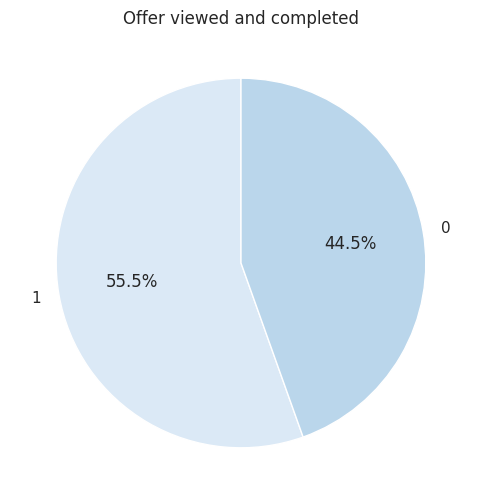

In [165]:
# plot how many of the offers viewed are also completed
data = offer_complete_df.offer_viewed_and_completed.value_counts(normalize=True)

# Visualize data
plt.figure(figsize=(6, 6))
sns.set_palette("Blues")  
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
plt.title("Offer viewed and completed")
plt.show()


## Model
We will be using the sklearn framework and an XGBoost model (binary classification) to do this prediction.

In [166]:
data = offer_complete_df
# assign offer_viewed_and_completed as target column
X,y = data.iloc[:,:-1], data['offer_viewed_and_completed']

# Split the dataset into teain and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
xgb_model = xgb.XGBClassifier()

# Fit the model 
xgb_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("F1-score:", f"{round(f1*100,2)}%")
print("Precision:", f"{round(precision*100,2)}%")
print("Recall:", f"{round(recall*100,2)}%")
print("Accuracy:", f"{round(accuracy*100,2)}%")


F1-score: 72.87%
Precision: 70.07%
Recall: 75.91%
Accuracy: 68.57%


In [167]:
# add the metrics to a datafram

#### Model results interpretation
The model achieved the following:  
Accuracy: The model predicted whether a user would complete and offer or not 68% of the time.  
Precision: 70% of the time that a model predicted an offer would be completed was correct.  
Recall: The model was able to identify 75% of the cases where an offer would be completed.  
F1-score: This metric balances precision and recall with a score of 72%.  

A potential way in which we can improve this model is by using grid search to select the best parameters for the model.

In [168]:
data = offer_complete_df
# assign offer_viewed_and_completed as target column
X, y = data.iloc[:, :-1], data['offer_viewed_and_completed']

# Split the dataset into teain and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the model
xgb_model = xgb.XGBClassifier()

# Set up grid search parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform grid search, using the f1 metric
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='f1')
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print the evaluation metrics
print("F1-score:", f"{round(f1*100,2)}%")
print("Precision:", f"{round(precision*100,2)}%")
print("Recall:", f"{round(recall*100,2)}%")
print("Accuracy:", f"{round(accuracy*100,2)}%")

F1-score: 72.96%
Precision: 70.05%
Recall: 76.12%
Accuracy: 68.62%


#### Model results interpretation - Metric used
Our main metric of interest is the F1-score which combines precision and recall into a single value and so provides a balanced assessment of a model's accuracy.

We only see a minor improvement in model results by using grid search. Alternative algorithms or enemble models may be tested to see if they work better for our use case. We may also go through additional feature engineering exercises to see if the model will perform better given different information. 

## Model Result Visualization
The below confusion matrix provides a visual representation of the model's performance by showing the counts of true positive, true negative, false positive, and false negative predictions.

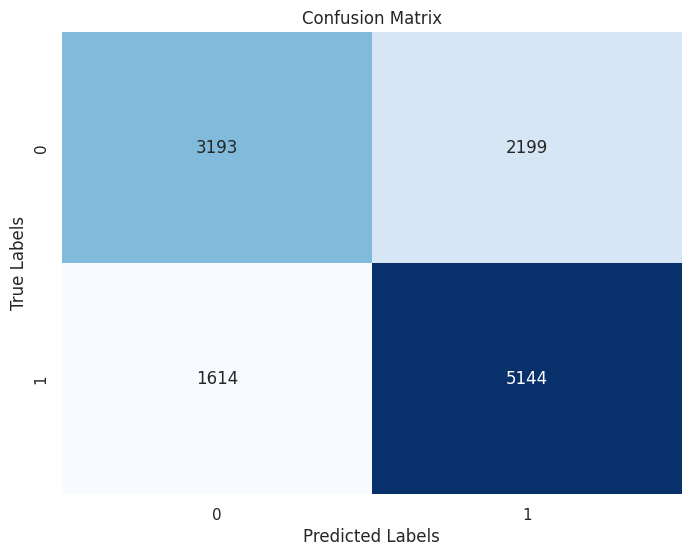

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


The confusion matrix indicates that there were 5144 True Positives in the model results and 3193 True Negatives.

## Transactions Analysis (Future work)
Now that we can predict if a user will complete and offer, it will be useful to see which users are the customers with the highest transaction values. This may be useful to see which offers these users respond to best.


In [170]:
transaction_df.sample(n=5)

,event,time,amount,age,user_id,income,days_as_member,F,M,O,bogo,discount,informational
189126,transaction,462,8.39,89.0,4c0b938c4e994b168f0062d7dbb79796,59000.0,2897.0,1.0,0.0,0.0,NaN,NaN,NaN
43604,transaction,108,26.62,83.0,5e4c04da5ccb48beab8b5644c14dabb2,115000.0,2835.0,1.0,0.0,0.0,NaN,NaN,NaN
80934,transaction,198,25.94,59.0,5cb65af515664bb0b39cdaa089244dc7,98000.0,2612.0,0.0,1.0,0.0,NaN,NaN,NaN
46338,transaction,120,8.13,40.0,6bb901d063a64c779320265b2aaeaee9,72000.0,2094.0,0.0,1.0,0.0,NaN,NaN,NaN
43003,transaction,102,13.46,25.0,4e9ba44fd1f54cfea60e2ef903c71b7f,70000.0,2786.0,1.0,0.0,0.0,NaN,NaN,NaN


In [171]:
# create a correlation matrix with amount
amount_corr = transaction_df.corr()[['amount']].sort_values(by='amount', ascending=False)
amount_corr

,amount
amount,1.000000
income,0.237198
age,0.091624
F,0.089546
time,0.005502
O,0.003051
days_as_member,-0.033388
M,-0.089781
bogo,NaN
discount,NaN


In [172]:
transaction_df[transaction_df.user_id =='27573d3ebc154a48a9cd245ae16b71a2']

,event,time,amount,age,user_id,income,days_as_member,F,M,O,bogo,discount,informational
38957,transaction,84,1.00,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1971.0,0.0,1.0,0.0,NaN,NaN,NaN
107542,transaction,312,3.66,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1971.0,0.0,1.0,0.0,NaN,NaN,NaN
110383,transaction,330,5.81,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1971.0,0.0,1.0,0.0,NaN,NaN,NaN
282668,transaction,624,2.31,26.0,27573d3ebc154a48a9cd245ae16b71a2,34000.0,1971.0,0.0,1.0,0.0,NaN,NaN,NaN


In [173]:
# group the transactions by user_id and sum the amount
transaction_df_group = transaction_df.groupby('user_id').agg({'amount': 'sum'}).reset_index()
transaction_df_group.head()

,user_id,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,0011e0d4e6b944f998e987f904e8c1e5,79.46
2,0020c2b971eb4e9188eac86d93036a77,196.86
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05
4,003d66b6608740288d6cc97a6903f4f0,48.34


In [174]:
# Future to-do, analyse which customers spend the most and target them with offers